### Feature Extraction

  



## Implementation of Reference Feature Extraction Methods in *pyspch*

#### From Spectrogram to Features

While a spectrogram is already a much more appealing representation than the raw speech waveform, we may still want to apply some FEATURE EXTRACTION on the spectrogram with as main purpose to present relevant information to the recognizer and to suppress disturbing, noisy side information at the same time

For the Feature Extraction we stick to a frame synchronous approach.  However, the features extracted at frame 'i' may well derive their information from many frames around 'i', e.g. in the case below the feature extraction spans 2N+1 frames

$$
\underbrace{ S_{i-N} \hspace{0.5cm} ... \text{  } S_i ... \hspace{0.5cm} S_{i+N} }_{F_i}
$$



This notebook shows how to do 2 prototypical feature extractions for speech recognition

a. Mel Frequency Cepstral Coefficients
- 39D feature vector consisting of 13 MFCCs with delta's and delta-delta's appendend
- 39D MFCCs are pretty much independent features 
- This feature extraction results in one of the best compact feature representations of speech, ideally suited for implementations with limited resources (computers, data, ... ).  These features are the reference features for HMM/GMM based systems.

b. High Resolution Mel Frequency Spectrum 
- high resolution (80 band) mel spectrum with splicing over a wide window (eg. 11 frames with stride 2, or 21 frames perceptive field)
- this results in a high dimensional feature vector capturing local and contextual information in all its detail.

Note: A more detailed demo and test of feature extraction functionalities may be found in tests/feature_test.ipynb 

#### *pyspch* standards and methods

- pyspsch and librosa
    + *pyspch* is built on top of librosa, numpy and scipy
    + *pyspch* uses the spectrogram arrangement (n_params,n_frames) as in librosa
    + *pyspsch* is often just a wrapper around librosa, and certain calls can be interchangeable
    + *pyspch* uses the 'dB' mode by default, but other modes (power, magnitude) can be used at any moment
- pyspch *framing* standards
   + *pyspch* uses the same framing approach as in SPRAAK or KALDI; i.e. frames are solely defined by shift parameter; 
    + frame i is positioned \[ i\*n_shift, (i+1)\*n_shift \] 
    + frame i is symmetrically extended to accomodate n_length and ultimately n_fft
    + padding via mirroring at the signal edges
    + n_frames = n_samples // n_shift
    + calling preemp_pad() prepares the waveform for processing with librosa 'without centering frames'
- mel spectrum
    + librosa defaults to conversion of full range spectrum
    + *pyspch* uses a smaller range, similar but not exact to kaldi 

In [36]:
%matplotlib inline
import os,sys, math
import numpy as np
import librosa
import pyspch.utils as U
import pyspch.sp as Sps
import pyspch.audio as Spa
import pyspch.io as Spio
import pyspch.display as Spd

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [12.0, 8.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'large'

### 1. Load a Waveform File

In [37]:
dir = 'https://homes.esat.kuleuven.be/~spchlab/data/'
name = 'misc/bad_bead_booed'
#name ='misc/b_8k'
name = 'misc/friendly'
#name = 'timit/si1027'
#
wavfname = os.path.join(dir,name+".wav")
wavdata, sr = Spa.load(wavfname)
if sr > 16000:  wavdata, sr = Spa.load(wavfname,sample_rate=16000) 


### 2. Fourier Spectrogram

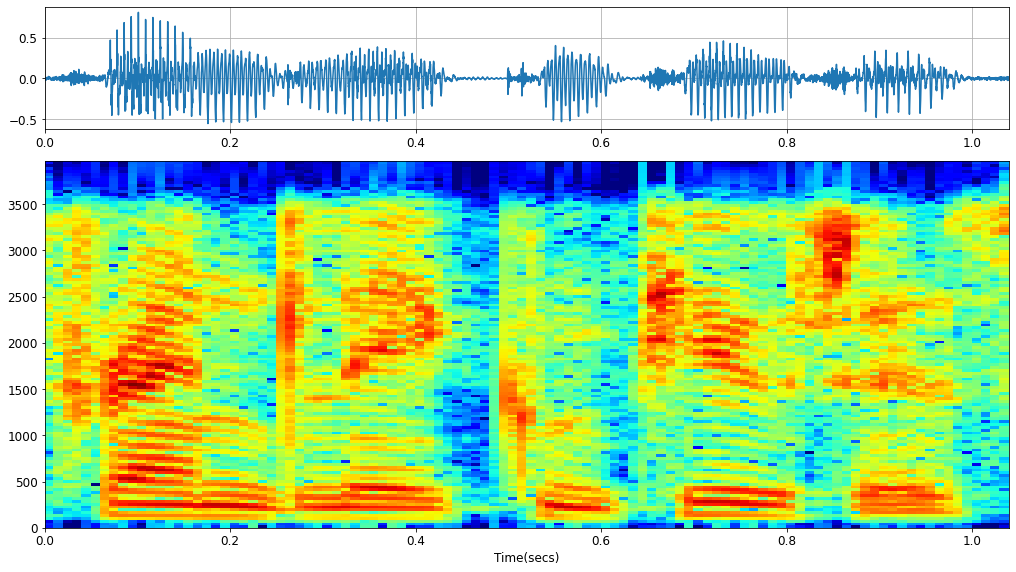

In [38]:
# compute a spectrogram as starting point for further analysis
shift=0.01
length=0.030
n_shift = int(shift*sr)
n_length = int(length*sr)
n_fft = 2**math.ceil(math.log2(n_length))
spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift,n_mels=None,mode='dB')
(n_param,n_frames)=spg.shape
d_freq = sr/(2.*(n_param-1))
fig = Spd.PlotSpg(wavdata=wavdata,spgdata=spg,sample_rate=sr,figsize=(14,8))
fig

### 3. Mel Frequency Cepstral Coefficients
39D MFCC's after mean norm  (perceptive field = 7 frames)

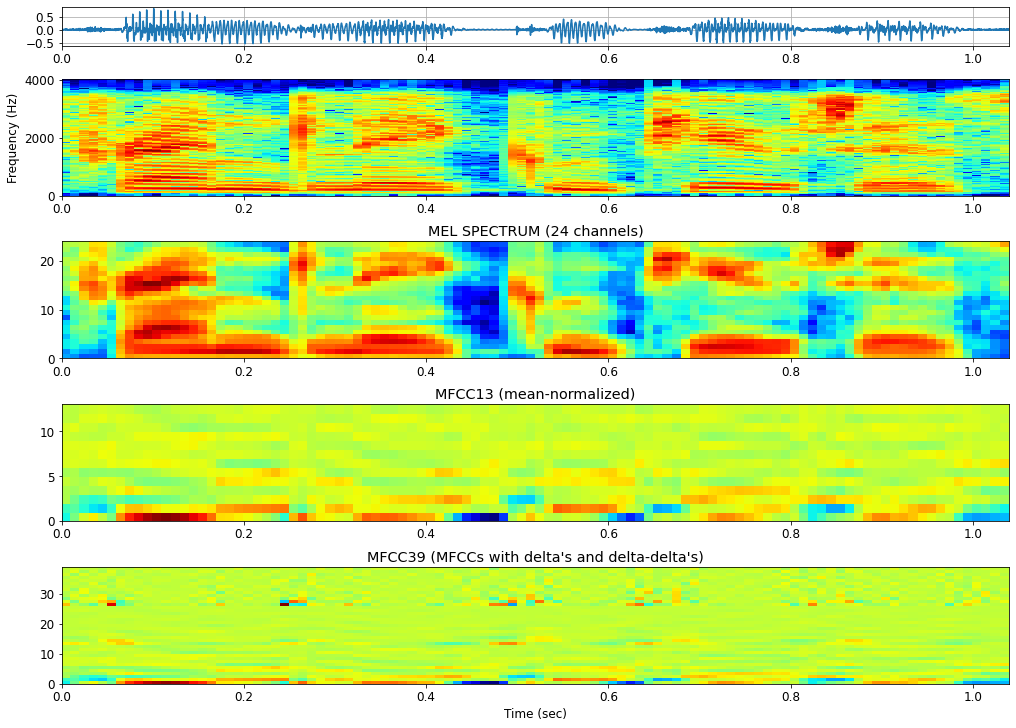

In [48]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift)
mel24 = Sps.spg2mel(spg,sample_rate=sr,n_mels=24)
mfcc13 = Sps.cepstrum(S=mel24,n_cep=13)
mfcc13_n = Sps.mean_norm(mfcc13)
mfcc39 = Sps.deltas(mfcc13_n,type="delta_delta2",Augment=True)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[mel24,mfcc13_n,mfcc39],sample_rate=sr,figsize=(14,10))
fig.axes[2].set_title("MEL SPECTRUM (24 channels)")
fig.axes[3].set_title("MFCC13 (mean-normalized)")
fig.axes[4].set_title("MFCC39 (MFCCs with delta's and delta-delta's)")
display(fig)

### 4. High Resolution Mel Spectra (with splicing over wide window)
- 11*80 mel spectra (stride 2, perceptive field = 21 frames)   
- in the picture we show the mel spectra , not the spliced feature vectors
- TBD: mean+variance normalized per file (OK ?)

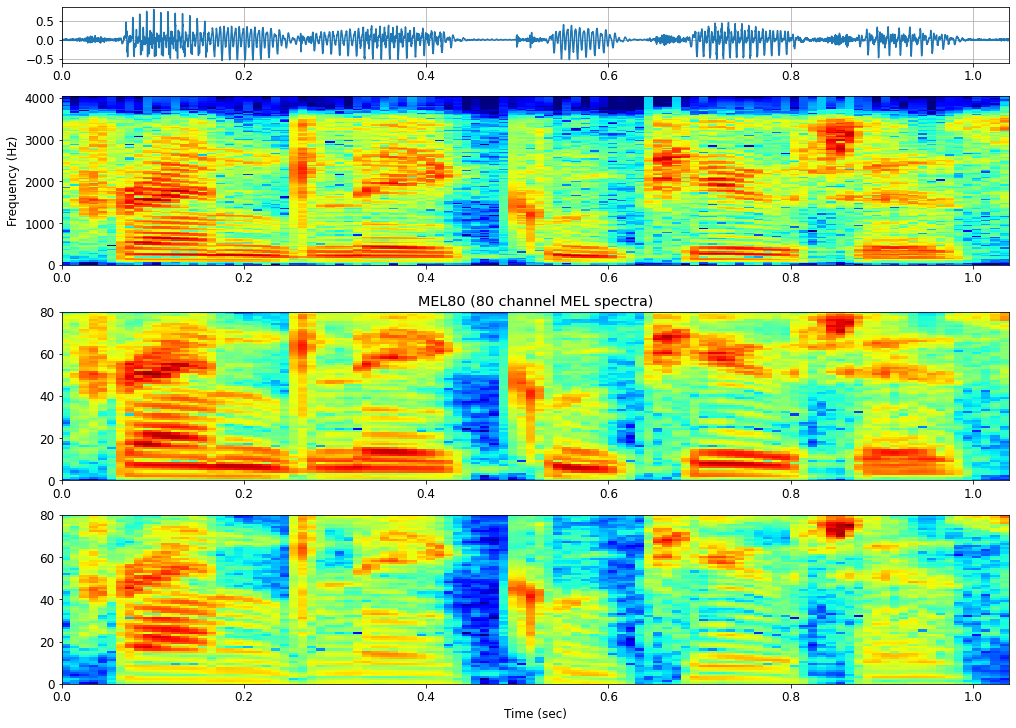

In [56]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,f_shift=shift)
mel80 = Sps.spg2mel(spg,sample_rate=sr,n_mels=80)
mel80_n = Sps.mean_norm(mel80,type="meanvar")
mel80s = Sps.splice_frames(mel80_n,N=5,stride=2)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,img_ftrs=[mel80,mel80_n],sample_rate=sr,figsize=(14,10))
fig.axes[2].set_title("MEL80 (80 channel MEL spectra)")
display(fig)

In [63]:

def fig_feature_extraction(frames=[0,1],iframe=iframe,mel=None,ftrs=None):
    wav1 = wavdata[frames[0]*n_shift:frames[1]*n_shift]
    pos = iframe*shift
    fig = Spd.SpchFig(row_heights=[1,3,3],figsize=(14,8))
    fig.add_line_plot(wav1, iax = 0,dx=1/sr,x0=frames[0]*n_shift/sr,ylabel='Waveform')
    fig.add_img_plot(mel[:,frames[0]:frames[1]], iax=1,dx=shift,x0=(frames[0]+.5)*shift,ylabel='Mel Spectrogram')
    fig.add_img_plot(ftrs[:,frames[0]:frames[1]], iax=2,dx=shift,x0=(frames[0]+.5)*shift,ylabel='Features')
    #fig.add_seg_plot(seg,iax=0,ypos=.82,color='#888',size=12,Lines=False)

    for i in range(-width,width+1):
        x0 = pos + (i-1) * shift
        fig.axes[0].axvspan(x0,x0+.03, color='#88F',alpha=.2,ec='b',lw=2.)    
    fig.axes[0].axvspan(pos-shift,pos+2.*shift, color='#88F',alpha=.6,ec='b',lw=7.)
    fig.axes[1].axvspan(pos,pos+shift, color='#88F',alpha=.6,ec='b',lw=7.)
    fig.axes[1].axvspan(pos-width*shift,pos+(width+1)*shift, color='#600',alpha=.5,ec='#F00',lw=5.,linestyle='-')
    fig.axes[2].axvspan(pos,pos+shift, color='#F00',alpha=.5,ec='#F00',lw=5.,linestyle='-')
    return(fig)

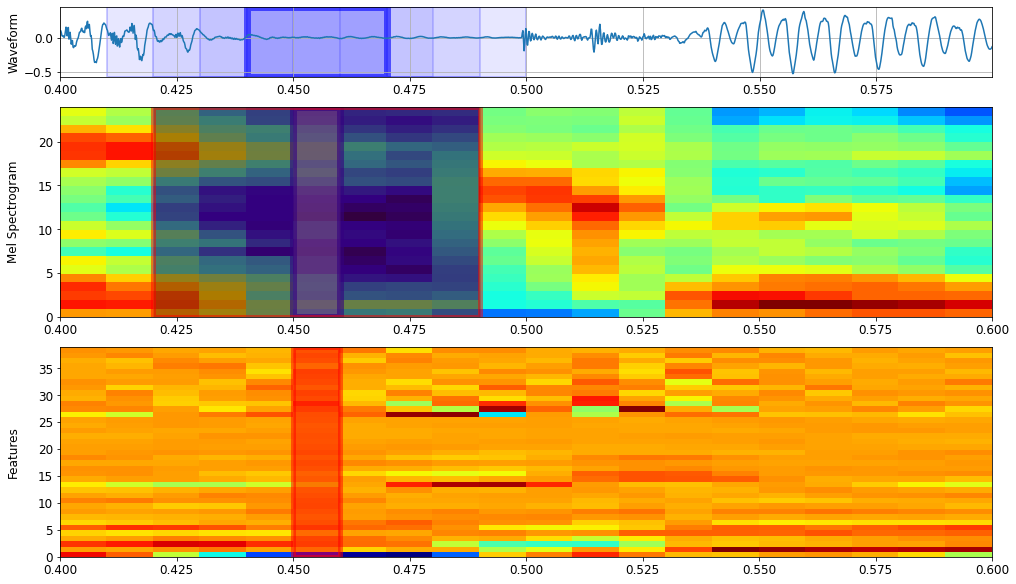

In [64]:
fig_feature_extraction(frames=[40,60],iframe=45,mel=mel24,ftrs=mfcc39)

In [54]:
def make_fig1(wavdata,spg,ftrs,sr=8000.,seg=None):
    pos = iframe*shift
    fig = Spd.SpchFig(row_heights=[1,3,3],figsize=(14,8))
    fig.add_line_plot(wavdata, iax = 0,dx=1/sr,ylabel='Waveform')
    fig.add_img_plot(spg, iax=1,dx=shift,dy=sr/(2.*spg.shape[0]),ylabel='Spectrogram')
    fig.add_img_plot(ftrs, iax=2,dx=shift,ylabel='Features')
    if seg is not None:
        fig.add_seg_plot(seg,iax=0,ypos=.82,color='#888',size=12,Lines=False)
    return(fig)

spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
ftrs = feature_extraction(spg=spg,n_mels=20,ncep=12,Deltas=True,Norm=None)
fig = make_fig1(wavdata,spg,ftrs)
display(fig)

NameError: name 'feature_extraction' is not defined

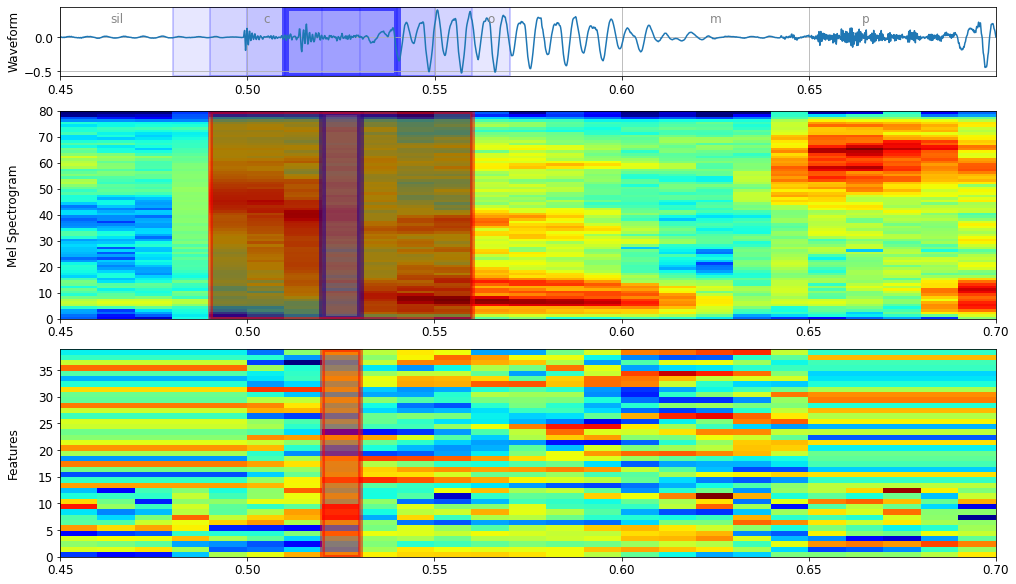

In [41]:
    
frames = [45,70]
n_mel = 80
n_cep = 13
width = 3
iframe = 50
pos = iframe*shift
wav1 = wavdata[frames[0]*n_shift:frames[1]*n_shift]

spgmel = Sps.spectrogram(wav1,sample_rate=sr,n_mels=n_mel)
mfcc = librosa.feature.mfcc(S=spgmel,sr=sr,n_mfcc=n_cep,dct_type=3)
mfcc_delta = librosa.feature.delta(mfcc,order=1)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

# creates a feature vector that stacks mfcc;2, delta's and double delta's
ftrs = np.vstack((mfcc,mfcc_delta,mfcc_delta2))
# mean and variance normalization
ftrs_n = (ftrs - ftrs.mean(axis=1,keepdims=True) )/ ftrs.std(axis=1,keepdims=True)

def fig_feature_extraction(iframe=iframe):
    pos = iframe*shift
    fig = Spd.SpchFig(row_heights=[1,3,3],figsize=(14,8))
    fig.add_line_plot(wav1, iax = 0,dx=1/sr,x0=frames[0]*n_shift/sr,ylabel='Waveform')
    fig.add_img_plot(spgmel, iax=1,dx=shift,x0=(frames[0]+.5)*shift,ylabel='Mel Spectrogram')
    fig.add_img_plot(ftrs_n, iax=2,dx=shift,x0=(frames[0]+.5)*shift,ylabel='Features')
    fig.add_seg_plot(seg,iax=0,ypos=.82,color='#888',size=12,Lines=False)

    for i in range(-width,width+1):
        x0 = pos + (i-1) * shift
        fig.axes[0].axvspan(x0,x0+.03, color='#88F',alpha=.2,ec='b',lw=2.)    
    fig.axes[0].axvspan(pos-shift,pos+2.*shift, color='#88F',alpha=.6,ec='b',lw=7.)
    fig.axes[1].axvspan(pos,pos+shift, color='#88F',alpha=.6,ec='b',lw=7.)
    fig.axes[1].axvspan(pos-width*shift,pos+(width+1)*shift, color='#600',alpha=.5,ec='#F00',lw=5.,linestyle='-')
    fig.axes[2].axvspan(pos,pos+shift, color='#F00',alpha=.5,ec='#F00',lw=5.,linestyle='-')
    return(fig)


fig=fig_feature_extraction(iframe=52)
display(fig)

In [ ]:
for ifr in range (45,65):
    fig = fig_feature_extraction(iframe=ifr)
    fig.savefig('computer_fr%d' %ifr)
    clear_output(wait=True)

In [42]:
w=interactive(fig_feature_extraction,iframe=widgets.IntSlider(min=frames[0],max=frames[1],value=50,
            description='Frame',layout=widgets.Layout(width='10in'))
             );
w

NameError: name 'interactive' is not defined

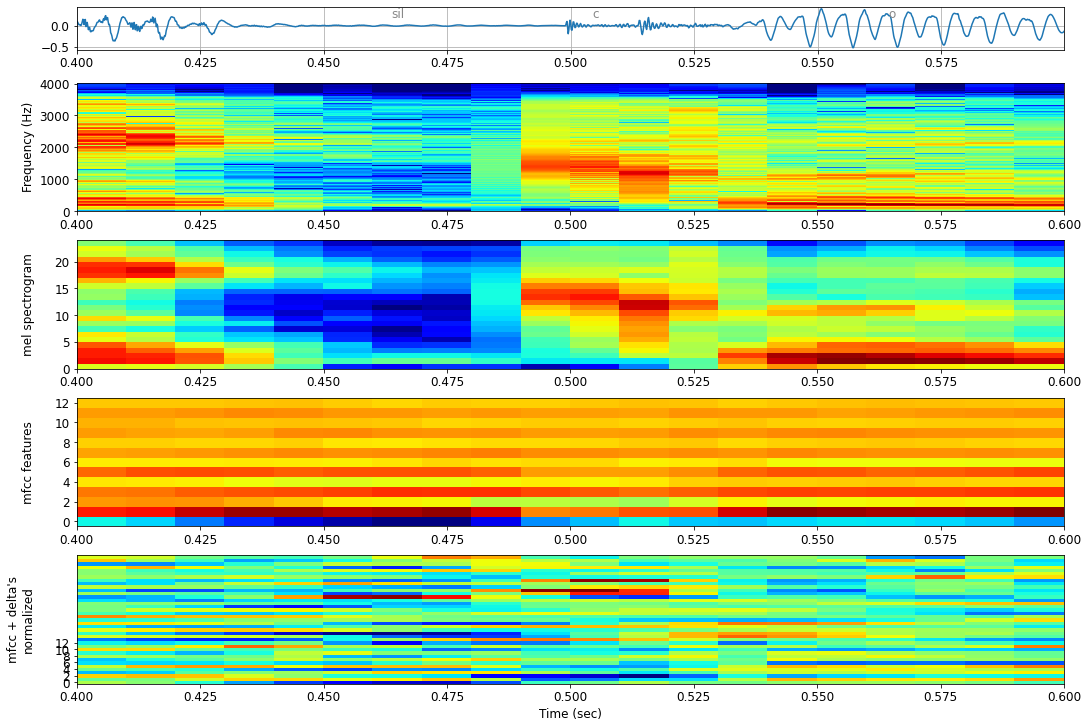

In [43]:
frames = [40,60]
n_mel = 24
n_cep = 13
mel80 = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=n_mel)
mfcc = librosa.feature.mfcc(S=mel80,sr=sr,n_mfcc=n_cep,dct_type=3)
mfcc_delta = librosa.feature.delta(mfcc)
mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
ftrs = np.vstack((mfcc,mfcc_delta,mfcc_delta2))
# mean and variance normalization
ftrs_n = (ftrs - ftrs.mean(axis=1,keepdims=True) )/ ftrs.std(axis=1,keepdims=True)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,frames=frames,sample_rate=sr,figsize=(15,10),
                img_ftrs=[mel80,mfcc,ftrs_n], img_labels=['mel spectrogram','mfcc features','mfcc + delta\'s\nnormalized'])
fig.axes[3].set_yticks(np.arange(0,n_cep,2)+0.5)
fig.axes[3].set_yticklabels(np.arange(0,n_cep,2))
fig.axes[4].set_yticks(np.arange(0,n_cep,2)+0.5)
fig.axes[4].set_yticklabels(np.arange(0,n_cep,2))

fig.add_seg_plot(seg,iax=0,ypos=.82,color='#888',size=12,Lines=False)
display(fig)

In [ ]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
def icepstrum(iframe,melFB,ncep):
    times=[iframe*shift,(iframe+1)*shift]
    itimes=[(iframe-1)*n_shift,(iframe+2)*n_shift]
    fig = Spd.SpchFig(col_widths=[3,1],row_heights=[1,3,3,3,3],figsize=(14,8))
    cep = cepstrum(spg,ncep=None)
    [env,res]=cepstrum_inv(cep,ncep=ncep,nspec=cep.shape[0])
    fig.add_line_plot(wavdata, iax = [0,0],dx=1/sr)
    fig.add_line_plot(wavdata[itimes[0]:itimes[1]],iax=[0,1],dx=1/sr,x0=itimes[0]/sr)
    fig.add_img_plot(spg, iax=[1,0],dx=shift)
    fig.add_line_plot(spg[:,iframe],iax=[1,1])
    fig.add_img_plot(cep, iax=[2,0],dx=shift,ylabel='Cepstrum')
    fig.add_line_plot(cep[:,iframe],iax=[2,1])
    fig.add_img_plot(env, iax=[3,0],dx=shift,ylabel='Envelope')
    fig.add_line_plot(env[:,iframe],iax=[3,1])
    fig.add_img_plot(res, iax=[4,0],dx=shift,ylabel='Residue')
    fig.add_line_plot(res[:,iframe],iax=[4,1])
    display(fig)

w=interactive(icepstrum,iframe=widgets.IntSlider(min=1,max=(nfr-2),value=nfr/2,
            description='Frame',layout=widgets.Layout(width='8in')),
            ncep=widgets.IntSlider(min=1,max=128,value=13,
                        description='#cep',layout=widgets.Layout(width='4in'))
             );
w

#self.wg_melfb = widgets.Checkbox(value=self.melfb,description='Mel Filterbank',indent=True,style=dw_0)
#        self.wg_nmels = widgets.IntSlider(value=self.nmels,min=10,max=128,step=1,description="#b",style=dw_3)

In [ ]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
cep = cepstrum(spg,ncep=13)

In [ ]:
cep1= np.vstack((cep,np.zeros((115,cep.shape[1]))))
cep1.shape

In [ ]:
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
cep = cepstrum(spg,ncep=None)
[env,res]=cepstrum_inv(cep,ncep=20,nspec=129)
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,frames=None,sample_rate=sr,figsize=(15,10),
                img_ftrs=[cep[1:,:],env,res], img_labels=['cep','env','res'])
fig

In [ ]:
nmel =80
ncep = 80

spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
spgmel = Sps.spg2mel(spg,sample_rate=sr,n_mels=nmel)
mfcc_1 = librosa.feature.mfcc(S=spgmel,sr=sr,n_mfcc=ncep,dct_type=3)
mfcc_2 = cepstrum(spgmel,ncep=ncep,sample_rate=sr)

In [ ]:
print(mfcc_1.shape, mfcc_2.shape)
fig,ax = plt.subplots(3,1)
ax[0].plot(mfcc_1[:,10])
ax[1].plot(mfcc_2[:,10]/13)
ax[2].plot(mfcc_1[:,10] - mfcc_2[:,10]/13)

In [ ]:
cep1 = cepstrum(spg,ncep=12)
cep1.shape

In [ ]:
cep2 = np.pad(cep1,((0,8),(0,0)))
cep1[:,0:3],cep2[:,0:3]

In [ ]:

ifr = 10
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
print(spg.shape)
fr1 = spg[:,ifr]
fr1_idct = fft.idct(fr1,type=3)
fr1_did = fft.dct(fr1_idct,type=3)
fr1, fr1_did
fig,ax=plt.subplots(1,2)
fig.axes[0].plot(spg[0,:])
fig.axes[1].plot(spg[128,:])

In [ ]:
import scipy.fft as fft
ifr=10
nmel=None
ncep=25
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
if nmel is None: spg2 =spg
else: spg2 = Sps.spg2mel(spg,sample_rate=sr,n_mels=nmel)
spg_idct = fft.idct(spg2,axis=0,type=3)
cep = np.zeros(spg_idct.shape)
cep[0:ncep,:]=spg_idct[0:ncep,:]
cepres = np.zeros(spg_idct.shape)
cepres[ncep:,:]=spg_idct[ncep:,:]
env = fft.dct(cep,axis=0,type=3)
res = fft.dct(cepres,axis=0,type=3)
#fig,ax=plt.subplots(4,1)
#fig.axes[0].plot(spg_in[:,10])
#fig.axes[1].plot(spg_idct[:,10])
#fig.axes[2].plot(cep_rec[:,10])
#fig.axes[3].plot(res_rec[:,10])
fig = Spd.PlotSpgFtrs(wavdata=wavdata,spgdata=spg,frames=None,sample_rate=sr,figsize=(15,10),
                img_ftrs=[cep,env,res], img_labels=['cep','env','res'])
fig